In [1]:
# 📘 08_RC_Filtros_RC_SecondOrder.ipynb
# Wave Digital Filters – Filtros RC de Segundo Orden (Cascada)
# ------------------------------------------------------------

# Objetivo:
# Implementar y analizar filtros RC de segundo orden (LowPass y HighPass) usando pywdf.
# Compararemos su comportamiento respecto a los filtros de primer orden.

# ------------------------------------------------------------
# 🔧 Setup
from pywdf.core.wdf import Resistor, Capacitor, SeriesAdaptor, IdealVoltageSource
from pywdf.core.circuit import Circuit
import numpy as np
import matplotlib.pyplot as plt
from scipy.io.wavfile import write


### 🧪 Clase base para filtros RC de segundo orden (cascada)

In [ ]:
class RC2LowPass(Circuit):
    def __init__(self, fs: float, cutoff: float):
        self.fs = fs
        self.cutoff = cutoff
        self.C = 1e-6
        self.R = 1.0 / (2 * np.pi * self.C * self.cutoff)

        # Etapa 1
        self.R1 = Resistor(self.R)
        self.C1 = Capacitor(self.C, self.fs)
        self.S1 = SeriesAdaptor(self.R1, self.C1)
        self.Vs1 = IdealVoltageSource(self.S1)
        self.stage1 = Circuit(self.Vs1, self.Vs1, self.C1)

        # Etapa 2
        self.R2 = Resistor(self.R)
        self.C2 = Capacitor(self.C, self.fs)
        self.S2 = SeriesAdaptor(self.R2, self.C2)
        self.Vs2 = IdealVoltageSource(self.S2)
        self.stage2 = Circuit(self.Vs2, self.Vs2, self.C2)

        self.output_stage = self.stage2
        super().__init__(self.Vs1, self.Vs1, self.C2)

    def process_sample(self, sample: float) -> float:
        y1 = self.stage1.process_sample(sample)
        y2 = self.stage2.process_sample(y1)
        return y2


class RC2HighPass(Circuit):
    def __init__(self, fs: float, cutoff: float):
        self.fs = fs
        self.cutoff = cutoff
        self.C = 1e-6
        self.R = 1.0 / (2 * np.pi * self.C * self.cutoff)

        # Etapa 1
        self.C1 = Capacitor(self.C, self.fs)
        self.R1 = Resistor(self.R)
        self.S1 = SeriesAdaptor(self.C1, self.R1)
        self.Vs1 = IdealVoltageSource(self.S1)
        self.stage1 = Circuit(self.Vs1, self.Vs1, self.R1)

        # Etapa 2
        self.C2 = Capacitor(self.C, self.fs)
        self.R2 = Resistor(self.R)
        self.S2 = SeriesAdaptor(self.C2, self.R2)
        self.Vs2 = IdealVoltageSource(self.S2)
        self.stage2 = Circuit(self.Vs2, self.Vs2, self.R2)

        self.output_stage = self.stage2
        super().__init__(self.Vs1, self.Vs1, self.R2)

    def process_sample(self, sample: float) -> float:
        y1 = self.stage1.process_sample(sample)
        y2 = self.stage2.process_sample(y1)
        return y2


### 📊 Análisis en frecuencia y tiempo



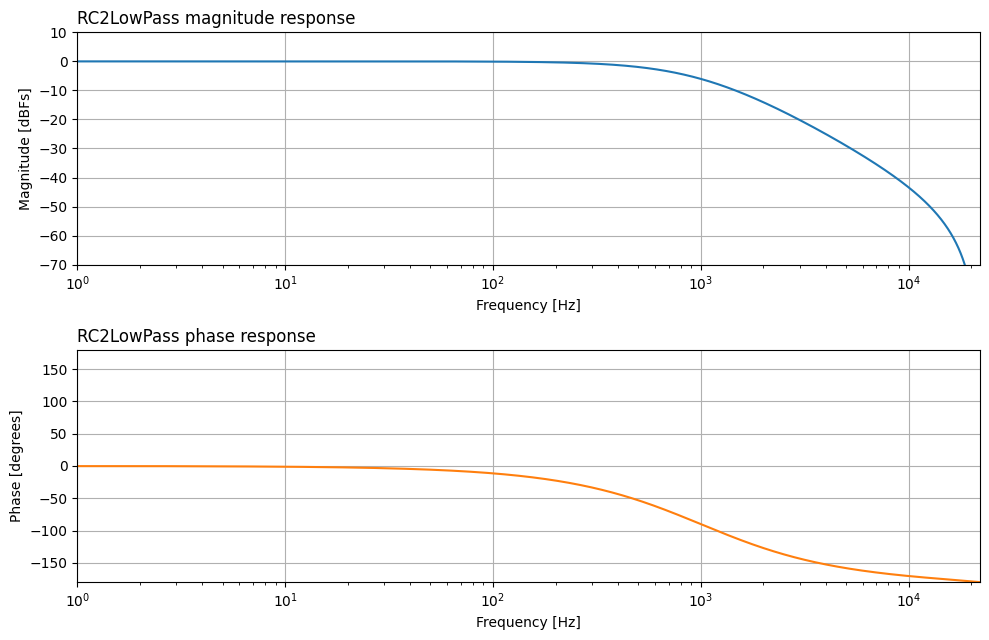

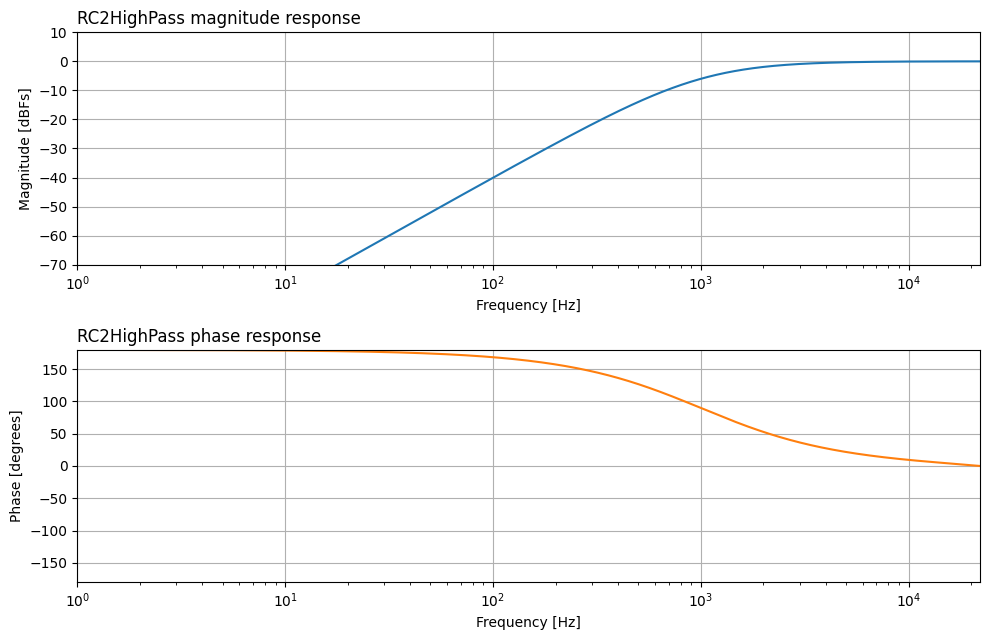

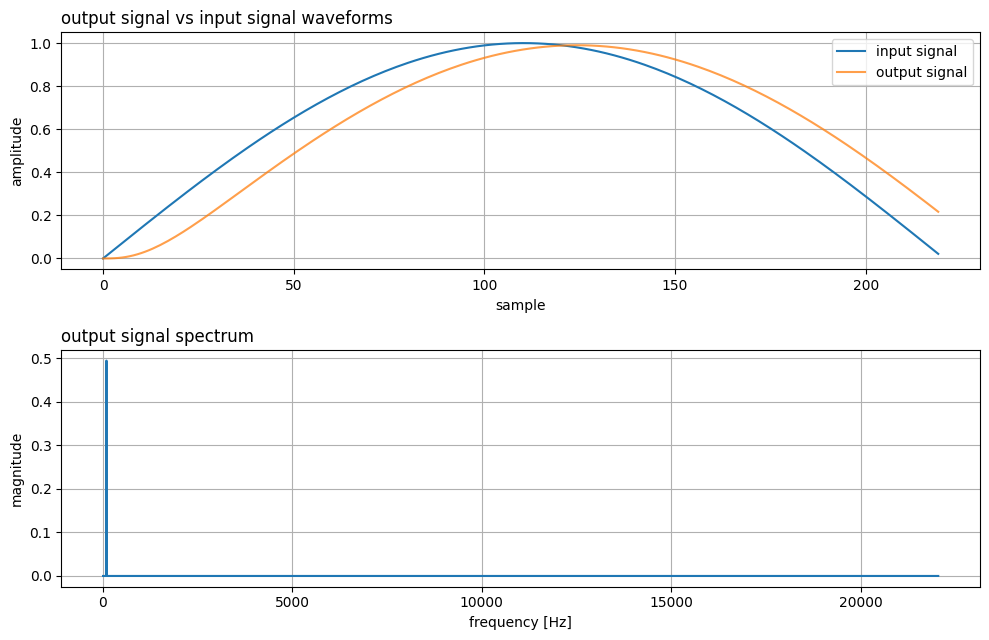

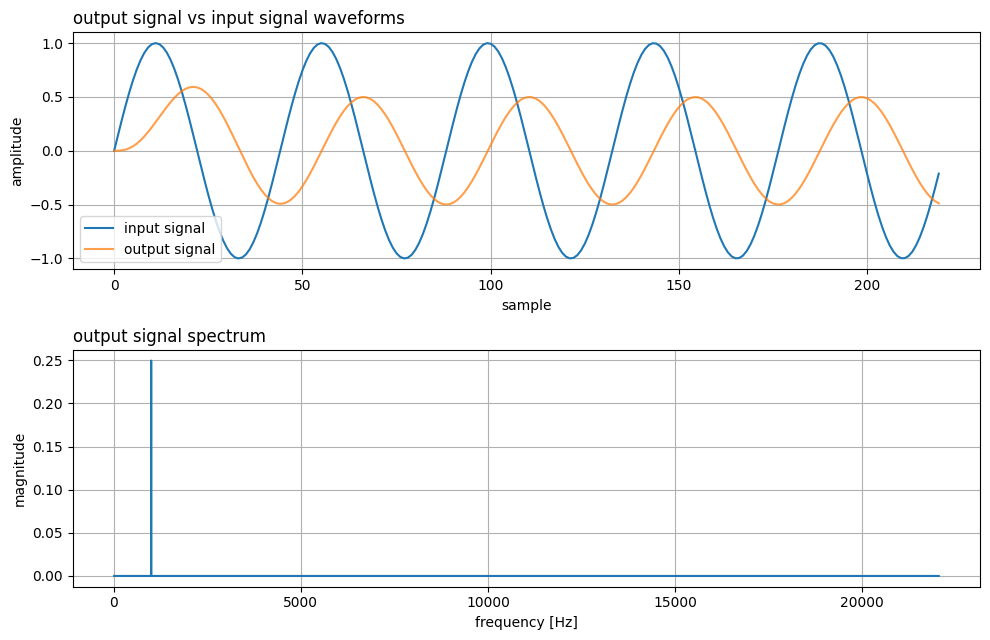

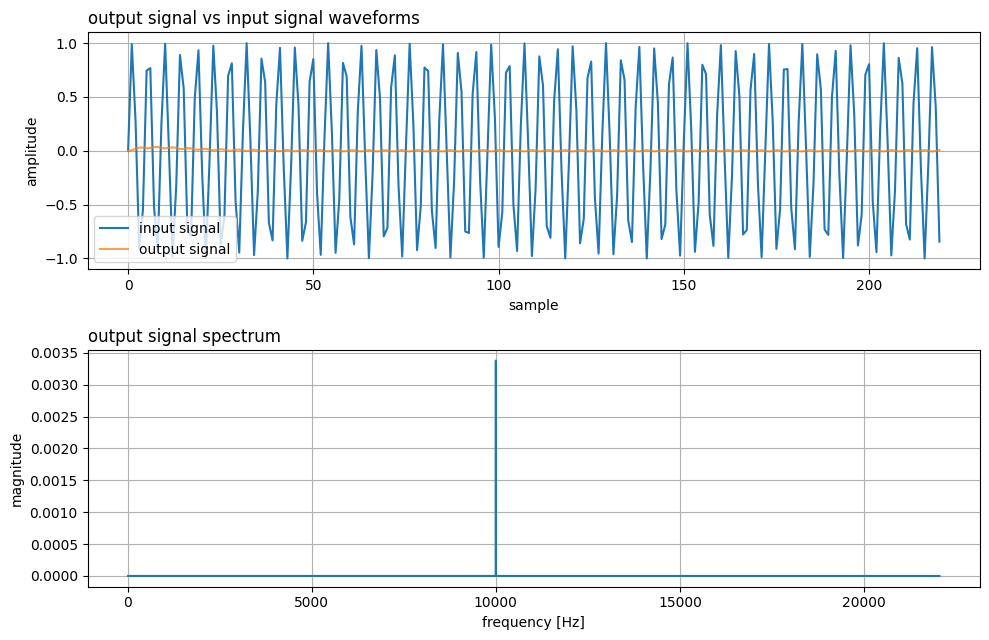

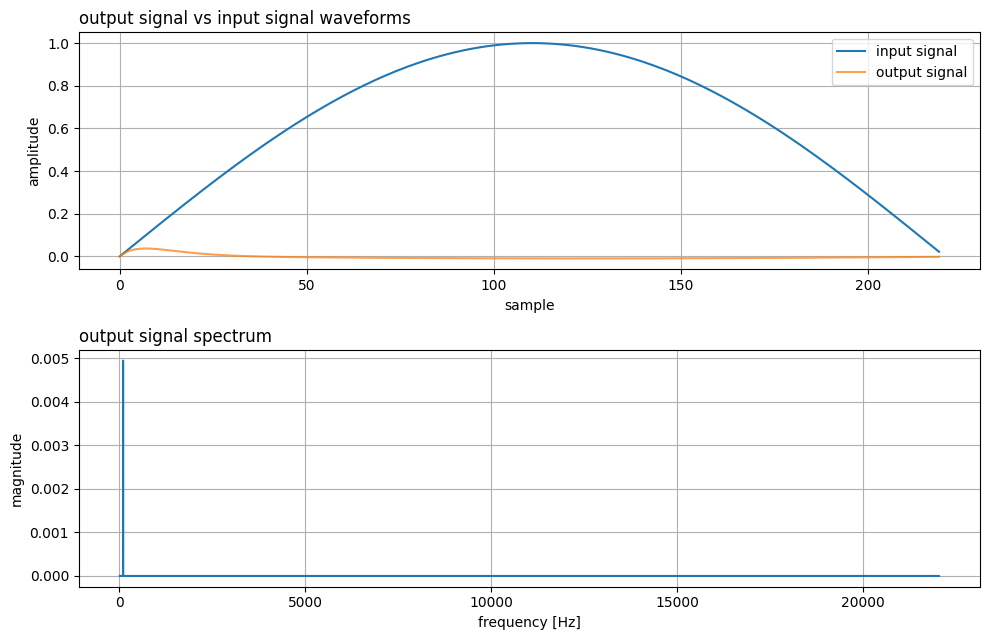

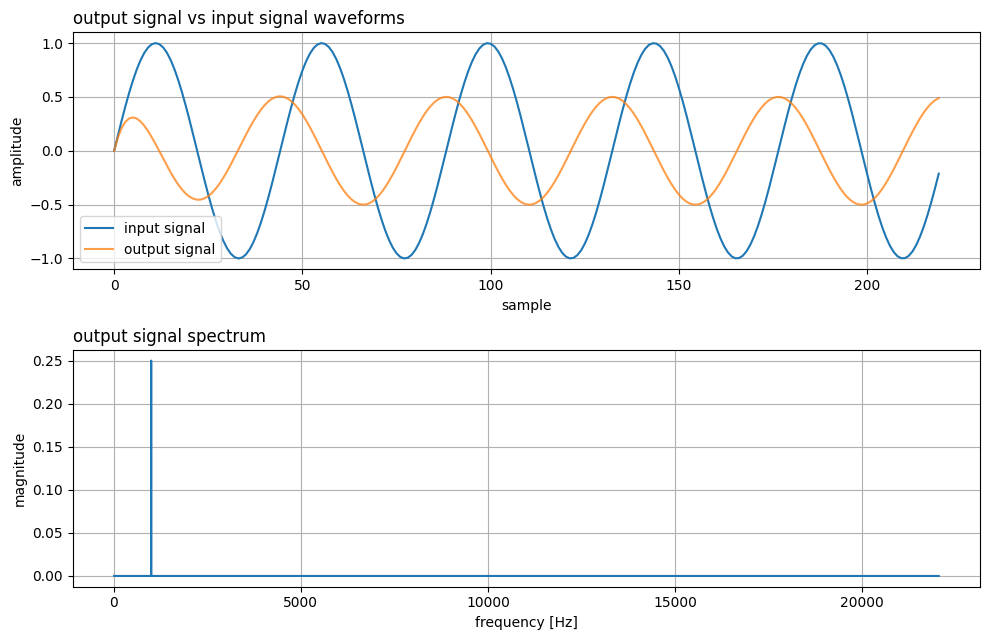

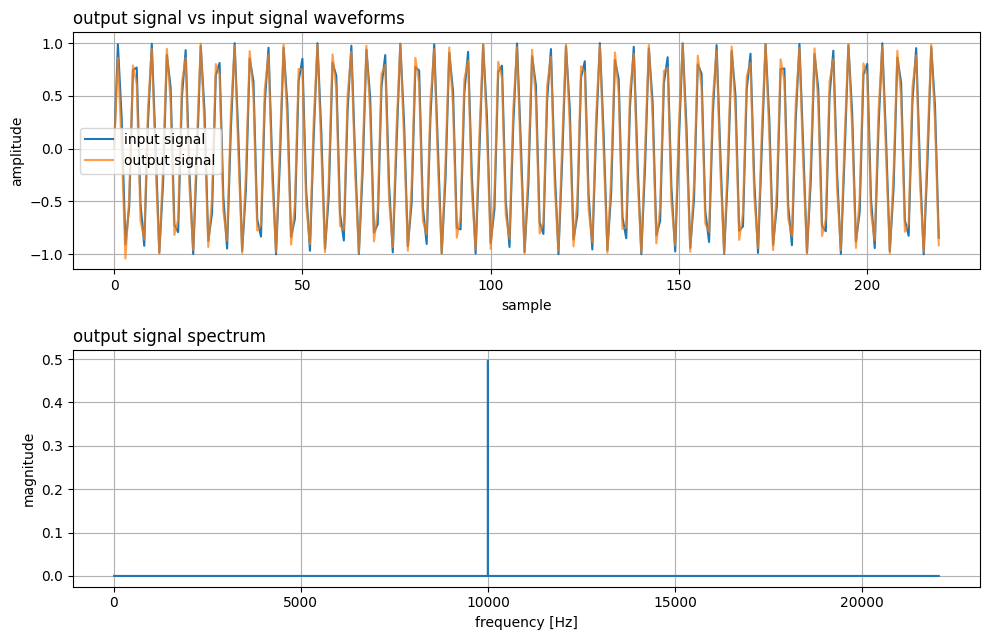

In [3]:
# Crear instancias
fs = 44100
cutoff = 1000

lpf2 = RC2LowPass(fs, cutoff)
hpf2 = RC2HighPass(fs, cutoff)

# Plot respuesta en frecuencia
lpf2.plot_freqz()
hpf2.plot_freqz()

# Señales seno de prueba
lpf2.AC_transient_analysis(freq=100, amplitude=1.0, t_ms=5)
lpf2.AC_transient_analysis(freq=1000, amplitude=1.0, t_ms=5)
lpf2.AC_transient_analysis(freq=10000, amplitude=1.0, t_ms=5)

hpf2.AC_transient_analysis(freq=100, amplitude=1.0, t_ms=5)
hpf2.AC_transient_analysis(freq=1000, amplitude=1.0, t_ms=5)
hpf2.AC_transient_analysis(freq=10000, amplitude=1.0, t_ms=5)


### 💾 Exportación de impulsos .wav


In [4]:
impulse = lpf2.get_impulse_response(delta_dur=1, amp=1)
write("rc_lowpass_2nd_order.wav", fs, impulse.astype(np.float32))

impulse = hpf2.get_impulse_response(delta_dur=1, amp=1)
write("rc_highpass_2nd_order.wav", fs, impulse.astype(np.float32))


## 📘 ¿Qué frecuencia de corte usar en una cascada de dos filtros RC?

Cuando cascamos dos filtros RC de primer orden con la **misma frecuencia de corte** \( f_c \), el sistema resultante tiene una mayor atenuación. Pero... **¿sigue siendo esa la frecuencia de corte efectiva?**

---

### ⚠️ El problema

Cada filtro individual atenúa –3 dB en su propia frecuencia de corte.  
Cuando cascas dos filtros con el mismo \( f_c \), la atenuación combinada es:

$$
H_{\text{total}}(f_c) = \left( \frac{1}{\sqrt{2}} \right)^2 = \frac{1}{2} \Rightarrow -6\, \text{dB}
$$

Esto significa que el sistema cascado atenúa **–6 dB** en lugar de –3 dB en \( f_c \).

---

### 🎯 ¿Y si queremos –3 dB en la salida total?

Debemos **corregir la frecuencia de corte** de cada etapa para que la combinación total tenga –3 dB en el punto deseado.  
La nueva frecuencia de corte para cada etapa debe ser:

$$
f_{c}^{(\text{etapa})} = \frac{f_{c}^{(\text{deseado})}}{\sqrt{\sqrt{2} - 1}} \approx 0.643 \cdot f_{c}
$$

---

### 🔬 Comparación visual

Veremos dos curvas:

- 🔵 Cascada sin corrección → –6 dB en \( f_c \)
- 🟠 Cascada corregida → –3 dB en \( f_c \)

Esto permite decidir cuál estrategia se ajusta mejor a tu objetivo sonoro.

---

### ✅ Conclusión

| Objetivo                                | Frecuencia de corte por etapa             |
|----------------------------------------|-------------------------------------------|
| Atenuación total de –6 dB en $$ f_c $$ | $$ f_c = \frac{1}{2\pi RC} $$             |
| Atenuación total de –3 dB en $$ f_c $$ | $$ f_c \approx 0.643 \cdot f_{c,\text{deseado}} $$ |

Ambas son válidas, pero producen resultados distintos.  
En la práctica (como en JUCE o plugins), se suele usar la versión sin corrección.



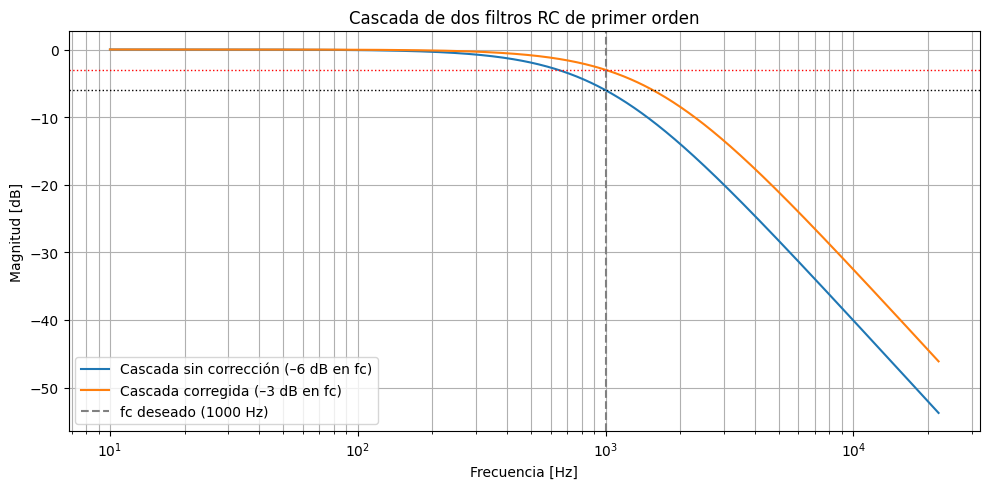

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Parámetros
fs = 44100
f_target = 1000  # frecuencia de corte deseada para el sistema completo
w = 2 * np.pi * np.logspace(1, np.log10(fs/2), 1000)

# RC para -6 dB en fc (cascada sin corrección)
RC_nominal = 1 / (2 * np.pi * f_target)
H1 = 1 / (1 + 1j * w * RC_nominal)
H_cascada_nominal = H1 * H1

# RC para -3 dB en fc (cascada corregida)
fc_corrected = f_target / np.sqrt(np.sqrt(2) - 1)
RC_corrected = 1 / (2 * np.pi * fc_corrected)
H2 = 1 / (1 + 1j * w * RC_corrected)
H_cascada_corrected = H2 * H2

# Plot
plt.figure(figsize=(10, 5))
plt.semilogx(w / (2*np.pi), 20 * np.log10(np.abs(H_cascada_nominal)), label="Cascada sin corrección (–6 dB en fc)")
plt.semilogx(w / (2*np.pi), 20 * np.log10(np.abs(H_cascada_corrected)), label="Cascada corregida (–3 dB en fc)")
plt.axvline(f_target, color='gray', linestyle='--', label='fc deseado (1000 Hz)')
plt.axhline(-3, color='red', linestyle=':', linewidth=1)
plt.axhline(-6, color='black', linestyle=':', linewidth=1)
plt.title("Cascada de dos filtros RC de primer orden")
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("Magnitud [dB]")
plt.grid(True, which='both')
plt.legend()
plt.tight_layout()
plt.show()


### 📘 RC2LowPass_Corrected (con –3 dB en f_c)


In [6]:
from pywdf.core.wdf import Resistor, Capacitor, SeriesAdaptor, IdealVoltageSource
from pywdf.core.circuit import Circuit
import numpy as np

class RC2LowPass_Corrected(Circuit):
    def __init__(self, fs: float, fc_desired: float):
        self.fs = fs
        self.fc_desired = fc_desired

        # Corrección para que la cascada tenga -3 dB en fc
        fc_corrected = fc_desired / np.sqrt(np.sqrt(2) - 1)
        self.C = 1e-6
        self.R = 1.0 / (2 * np.pi * self.C * fc_corrected)

        # Etapa 1
        self.R1 = Resistor(self.R)
        self.C1 = Capacitor(self.C, self.fs)
        self.S1 = SeriesAdaptor(self.R1, self.C1)
        self.Vs1 = IdealVoltageSource(self.S1)
        self.stage1 = Circuit(self.Vs1, self.Vs1, self.C1)

        # Etapa 2
        self.R2 = Resistor(self.R)
        self.C2 = Capacitor(self.C, self.fs)
        self.S2 = SeriesAdaptor(self.R2, self.C2)
        self.Vs2 = IdealVoltageSource(self.S2)
        self.stage2 = Circuit(self.Vs2, self.Vs2, self.C2)

        # Inicializa la clase base con la salida del segundo filtro
        super().__init__(source=self.Vs1, root=self.Vs1, output=self.C2)

    def process_sample(self, sample: float) -> float:
        y1 = self.stage1.process_sample(sample)
        y2 = self.stage2.process_sample(y1)
        return y2


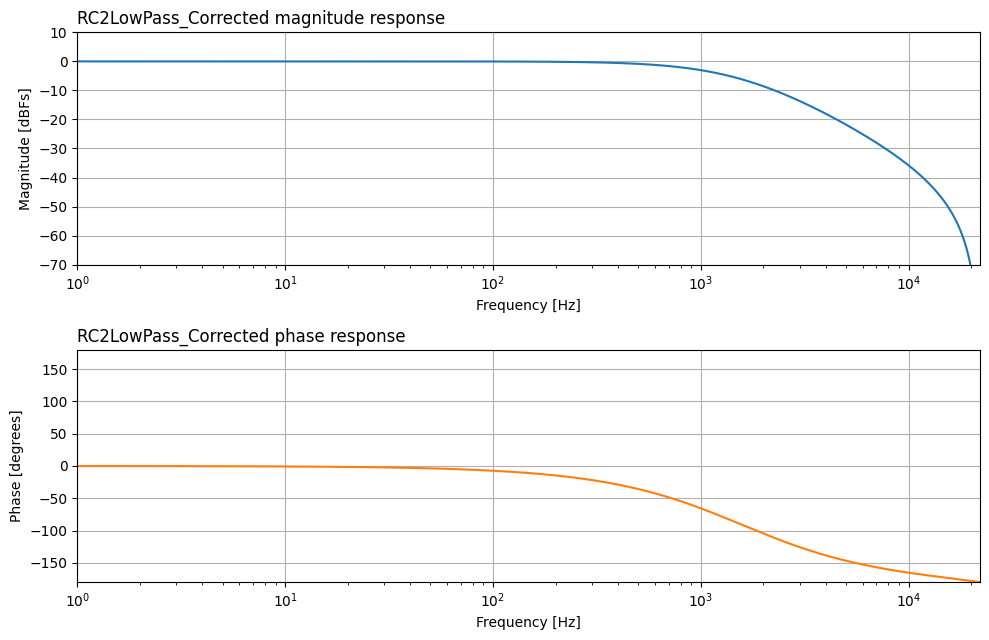

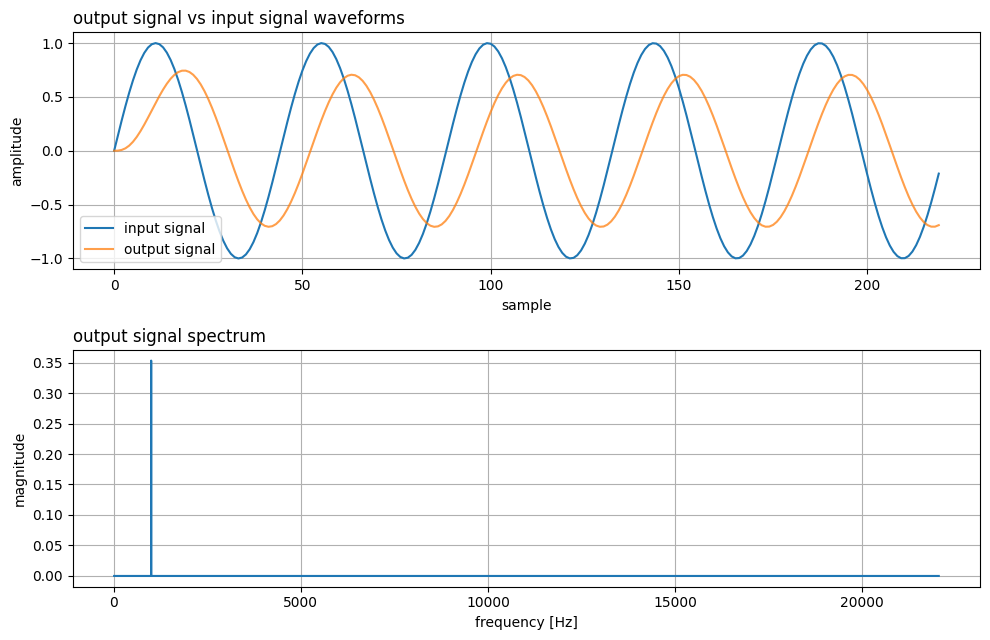

In [7]:
corrected_filter = RC2LowPass_Corrected(fs=44100, fc_desired=1000)
corrected_filter.plot_freqz()
corrected_filter.AC_transient_analysis(freq=1000, amplitude=1.0, t_ms=5)
